In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import olac.maths as mf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
from __future__ import division, print_function
import numpy as np

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=2, drift=0):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    pos_csum = [0, 0]  # gp
    neg_csum = [0, 0]  # gn

    x = np.atleast_1d(x).astype('float64')
    alarm_index = []
    change_index = []
    pos_alarm_index = 0
    neg_alarm_index = 0

    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        pos_csum.append(pos_csum[i-1] + s - drift)  # cumulative sum for + change
        neg_csum.append(neg_csum[i-1] - s - drift)  # cumulative sum for - change

        if pos_csum[i] < 0:
            pos_csum[i], pos_alarm_index = 0, i
        if neg_csum[i] < 0:
            neg_csum[i], neg_alarm_index = 0, i
        if pos_csum[i] > threshold or neg_csum[i] > threshold:  # change detected!
            alarm_index = np.append(alarm_index, i)    # alarm index
            if pos_csum[i] > threshold:
                change_index = np.append(change_index, pos_alarm_index)  # start
            else:
                change_index = np.append(change_index, neg_alarm_index)  # start

            pos_csum[i], neg_csum[i] = 0, 0      # reset alarm

    return alarm_index, change_index

In [9]:
N = 1000

In [213]:
def mean_break_data_set(N, mu_break=1, mu=0, sigma=0.3, nr_breaks=1, len_breaks=None, func=np.random.normal):
    len_breaks = len_breaks or [int(np.ceil(N / (5 + np.random.normal(0, 4)))) for i in range(nr_breaks)]
    n_sets = nr_breaks + 2
    
    datasets = [func(mu, sigma, size=(N, 1)) for i in range(n_sets)]
    setslabels = [[False] * N for i in range(n_sets)]
    breaks = [False] * n_sets
    
    datasets.extend([func(mu_break, sigma, size=(len_breaks[i], 1)) for i in range(nr_breaks)])
    setslabels.extend([[True] * len_breaks[i] for i in range(nr_breaks)])

    n_datasets = len(datasets)
    set_order = np.random.choice(range(n_datasets), size=n_datasets, replace=False)
    breaks.extend([True] * nr_breaks)
    print('mu', mu)
    print('mu break', mu_break)
    print('sigma', sigma)
    print('')
    print('# breaks: ', nr_breaks)
    print('length breaks: ', len_breaks)
    print('Order breaks: ', np.array(breaks)[set_order])
    print()
    return np.hstack((np.vstack([datasets[i] for i in set_order]), np.hstack([setslabels[i] for i in set_order])[:, None]))

mu 0
mu break 0.5
sigma 0.3

# breaks:  2
length breaks:  [135, 223]
Order breaks:  [False  True  True False False False]



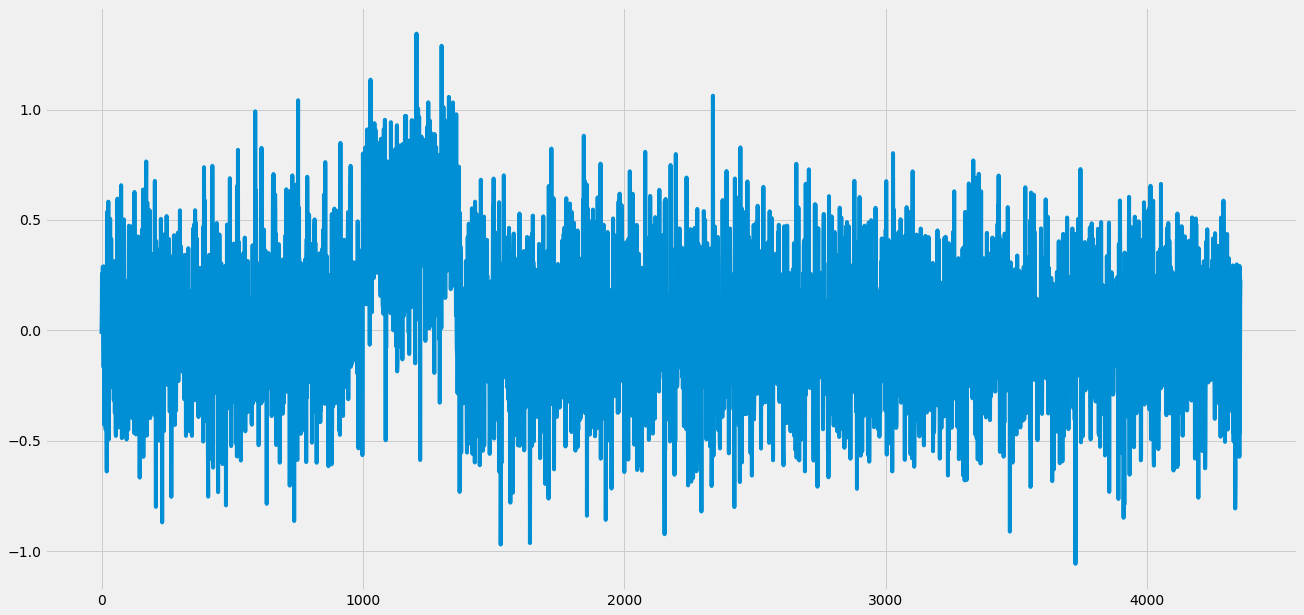

In [214]:
mean_break = mean_break_data_set(N, mu_break=0.5, nr_breaks=2)
plt.figure(figsize=(20, 10))
plt.plot(mean_break[:, 0]);

In [125]:
mean_break

array([[-0.1680261 ,  0.        ],
       [ 0.19797577,  0.        ],
       [ 0.49309086,  0.        ],
       ...,
       [-0.24652751,  0.        ],
       [-0.35584932,  0.        ],
       [ 0.22873433,  0.        ]])

The CUSUM input can be any filter residual, for instance the prediction error from a Kalman filter.
The CUSUM test is as follows:
g0 = 0
gt = max (0, gt−1 + εt − υ)
if gt > h then alarm and gt =0
The CUSUM test is memoryless, and its accuracy depends on the choice of parameters υ and h.

In [199]:
class CUSUM():
    def __init__(self, h, v):
        self.gp = [0]
        self.gn = [0]
        self.h = h
        self.hm = -1 * h
        self.v = v
        self.alarm = False
    
    def update(self, delta):
        self.gp.append(max((0, self.gp[-1] + delta - self.v)))
        self.gn.append(min((0, self.gn[-1] + delta - self.v)))
        
        if (self.gp[-1] > self.h) or (self.gn[-1] < self.hm):
            print("ALARM")
            print()
            return True
        else:
            return False
    
    def run(self, x):
        i = 0
        while not self.alarm:
            self.alarm = self.update(x[i, 0])
            i += 1
            if i >= len(x):
                break
        
            

In [202]:
cusum = CUSUM(h=5, v=0)

In [203]:
cusum.run(mean_break)

ALARM


In [131]:
%timeit max((0, 2))

158 ns ± 4.04 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [130]:
%timeit np.max((0, 2))

5.05 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
